In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from transformers import (
    AutoProcessor, 
    AutoModelForCausalLM, 
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from PIL import Image
from tqdm import tqdm
import os
import glob
import random
from huggingface_hub import login
login("YOUR_HF_TOKEN_HERE")
import albumentations as A
from albumentations.pytorch import ToTensorV2


2025-09-17 17:09:30.626385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758128970.828205      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758128970.886658      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Florence

In [3]:
from transformers import AutoModelForCausalLM, AutoProcessor
from peft import PeftModel

base_model_id = "microsoft/Florence-2-base-ft"
repo_id = "Alasil/Florence_classification"
subfolder = "florence2-disaster-best-f1-0.9690"
# 1. Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True
)

new_model = PeftModel.from_pretrained(
    base_model,
    repo_id,
    subfolder=subfolder,   # 👈 load correct adapter inside repo
    is_trainable=False)


# 3. Load processor
processor = AutoProcessor.from_pretrained(base_model_id, trust_remote_code=True)

# 4. Merge weights
Final_model = new_model.merge_and_unload()

print("✅ Adapter loaded:", Final_model.peft_config if hasattr(Final_model, "peft_config") else "None")


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/463M [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

florence2-disaster-best-f1-0.9690/adapte(…):   0%|          | 0.00/21.3M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ Adapter loaded: {'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='microsoft/Florence-2-base-ft', revision=None, inference_mode=True, r=64, target_modules={'q_proj', 'k_proj', 'o_proj', 'v_proj'}, exclude_modules=None, lora_alpha=128, lora_dropout=0.07, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Final_model.to(device)
Final_model.eval()

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): Depth

In [5]:
def extract_class_from_completion_robust(generated_text):
    """Robust extraction that handles variations in generated text"""
    text = generated_text.lower().replace("<more_detailed_caption>", "").strip()
    
    # Score-based approach with multiple patterns per class
    class_patterns = {
        1: {  # fire
            'primary': ['fire scene', 'fire'],
            'secondary': ['fire', 'burning', 'flames', 'blaze'],
            'context': ['this is', 'shows', 'depicts']
        },
        0: {  # collapsed_building  
            'primary': ['collapsed building scene', 'building collapse'],
            'secondary': ['collapsed', 'destroyed building', 'building damage', 'structural damage'],
            'context': ['this is', 'shows', 'depicts']
        },
        2: {  # flooded_areas
            'primary': ['flooded area scene', 'flooding scene'],
            'secondary': ['flood', 'flooded', 'water damage', 'inundated'],
            'context': ['this is', 'shows', 'depicts']
        },
        4: {  # traffic_incident
            'primary': ['traffic incident scene', 'traffic accident'],
            'secondary': ['accident', 'crash', 'collision', 'vehicle damage', 'car damaged'],
            'context': ['this is', 'shows', 'depicts']
        },
        3: {  # normal
            'primary': ['normal scene'],
            'secondary': ['normal', 'regular', 'typical', 'ordinary'],
            'context': ['this is', 'shows', 'depicts']
        }
    }
    
    class_scores = {}
    
    for class_idx, patterns in class_patterns.items():
        score = 0
        
        # High weight for primary patterns
        for pattern in patterns['primary']:
            if pattern in text:
                score += 3
        
        # Medium weight for secondary keywords
        for keyword in patterns['secondary']:
            if keyword in text:
                score += 2
        
        # Bonus for proper context (indicates it's a description)
        for context in patterns['context']:
            if context in text:
                score += 1
                break
        
        class_scores[class_idx] = score
    
    # Return class with highest score
    if max(class_scores.values()) > 0:
        original_class = max(class_scores, key=class_scores.get)
        # Map 5-class indices to 2-class indices for your dataset
        if original_class == 1:  # fire -> 0
            return 0
        elif original_class == 3:  # normal -> 1  
            return 1
        else:
            return 1  # default to normal (anything else -> 1)
    else:
        return 1  # default to normal

**Trial on multiple images**

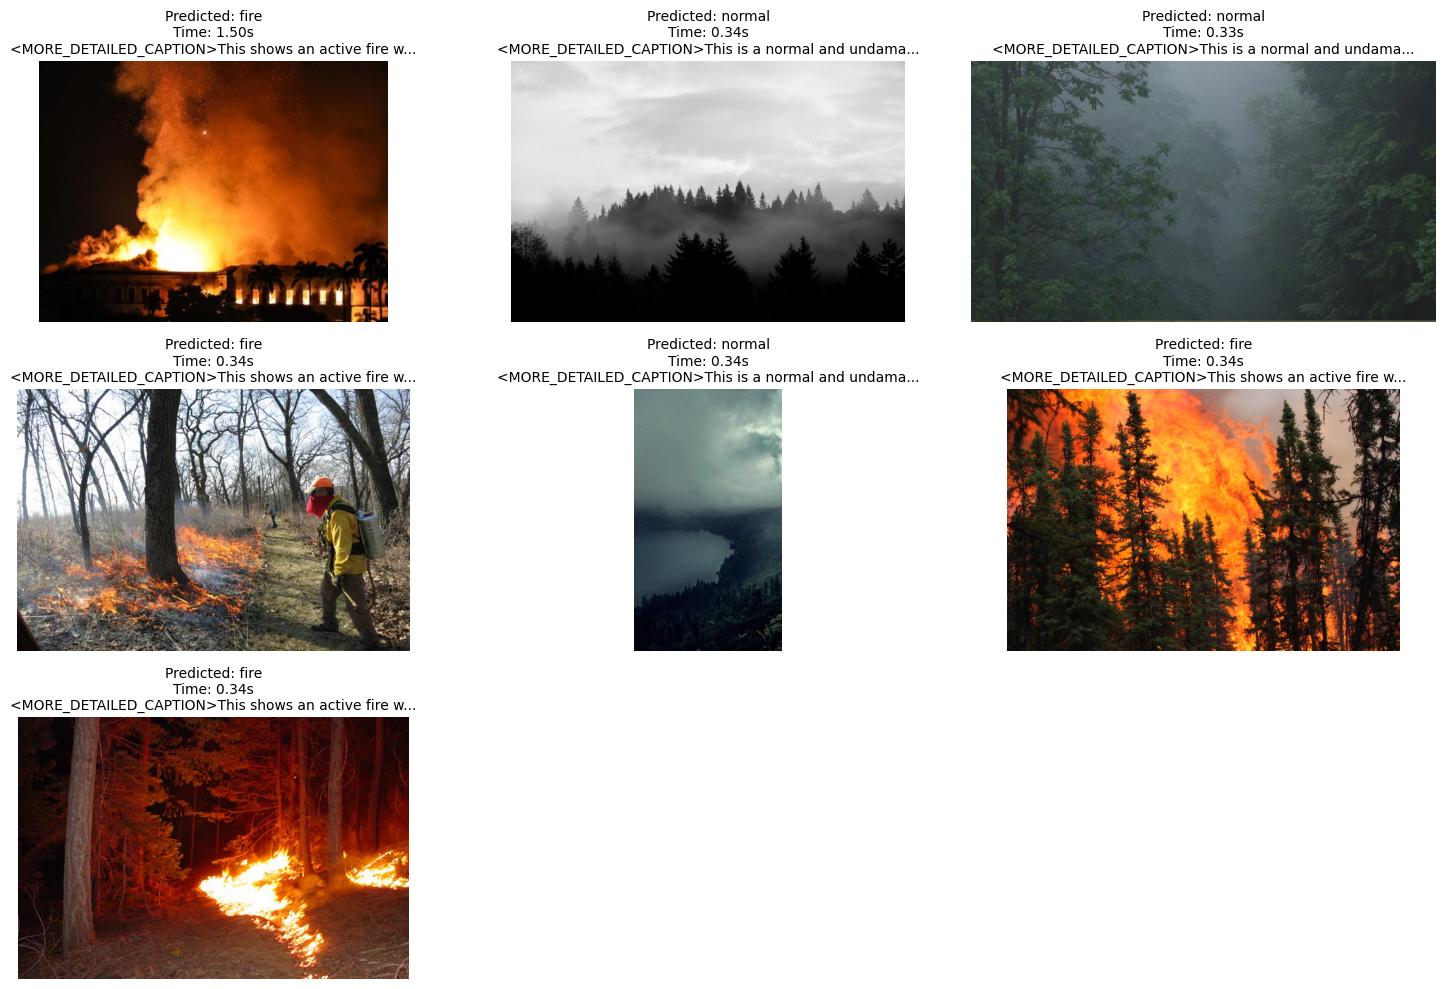

In [6]:
import time
from PIL import Image
import matplotlib.pyplot as plt
import torch

# List of test images
image_paths = [
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0001.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0001.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0005.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0007.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0011.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0010.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0008.png"
]

class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]

plt.figure(figsize=(15, 10))
torch_dtype = torch.float32  # Match your training dtype

for idx, img_path in enumerate(image_paths):
    image = Image.open(img_path)
    prompt = "<MORE_DETAILED_CAPTION>"

    # Prepare inputs
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch_dtype)

    # Measure time
    start_time = time.time()
    with torch.no_grad():
        generated_ids = Final_model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,
            num_beams=3,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id
        )
    end_time = time.time()

    # Decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    predicted_class = extract_class_from_completion_robust(generated_text)
    
    # Plot the image
    plt.subplot(3, 3, idx + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted_class]}\nTime: {end_time - start_time:.2f}s\n{generated_text[:50]}...", fontsize=10)

plt.tight_layout()
plt.show()


In [7]:
import time
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import numpy as np
from tqdm import tqdm
import pandas as pd

# 🔹 Load dataset (class names come from folder names)
dataset = datasets.ImageFolder(
    root="/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train"
)

# 🔹 Original classes
print("Original classes:", dataset.classes)   # ['fire', 'nofire']

# 🔹 Remap "nofire" -> "normal" 
class_names = ["fire" if c == "fire" else "normal" for c in dataset.classes]
print("Mapped classes:", class_names)
print(f"Total images in dataset: {len(dataset.samples)}")



print("Using your original function with proper index mapping: fire(1->0), normal(3->1)")

Original classes: ['fire', 'nofire']
Mapped classes: ['fire', 'normal']
True label: fire


In [ ]:
# Initialize lists to store results
all_predictions = []
all_true_labels = []
all_processing_times = []
all_generated_texts = []
all_image_paths = []

# Process entire dataset
print("Processing entire dataset...")
for idx, (img_path, true_label) in enumerate(tqdm(dataset.samples, desc="Processing images")):
    try:
        # Load image
        image = Image.open(img_path)
        prompt = "<MORE_DETAILED_CAPTION>"
        
        # Prepare inputs
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch_dtype)
        
        # Measure time
        start_time = time.time()
        with torch.no_grad():
            generated_ids = Final_model.generate(
                **inputs,
                max_new_tokens=150,
                do_sample=False,
                num_beams=3,
                pad_token_id=processor.tokenizer.pad_token_id,
                eos_token_id=processor.tokenizer.eos_token_id
            )
        end_time = time.time()
        processing_time = end_time - start_time
        
        # Decode
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predicted_class = extract_class_from_completion_robust(generated_text)
        
        # Debug: Print first few predictions to see what's happening
        if idx < 5:
            print(f"\nDEBUG - Image {idx}:")
            print(f"Generated text: {generated_text}")
            print(f"Predicted class index: {predicted_class}")
            print(f"Predicted class name: {class_names[predicted_class] if predicted_class is not None and predicted_class < len(class_names) else 'INVALID'}")
            print(f"True class index: {true_label}")
            print(f"True class name: {class_names[true_label]}")
        
        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(true_label)
        all_processing_times.append(processing_time)
        all_generated_texts.append(generated_text)
        all_image_paths.append(img_path)
        
        # Optional: Print progress every 100 images
        if (idx + 1) % 100 == 0:
            accuracy = np.mean(np.array(all_predictions) == np.array(all_true_labels))
            avg_time = np.mean(all_processing_times)
            print(f"Processed {idx + 1}/{len(dataset.samples)} images")
            print(f"Current accuracy: {accuracy:.3f}")
            print(f"Average processing time: {avg_time:.3f}s")
            print("-" * 50)
            
    except Exception as e:
        print(f"Error processing image {idx} ({img_path}): {str(e)}")
        # Store None values for failed images
        all_predictions.append(None)
        all_true_labels.append(true_label)
        all_processing_times.append(0)
        all_generated_texts.append("")
        all_image_paths.append(img_path)

In [ ]:
# Calculate final metrics
valid_predictions = [(pred, true) for pred, true in zip(all_predictions, all_true_labels) if pred is not None]

Original classes: ['fire', 'nofire']
Mapped classes: ['fire', 'normal']
Total images in dataset: 2947
Using your original function with proper index mapping: fire(1->0), normal(3->1)
Processing entire dataset...


Processing images:   0%|          | 1/2947 [00:00<23:47,  2.06it/s]


DEBUG - Image 0:
Generated text: <MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke
Predicted class index: 0
Predicted class name: fire
True class index: 0
True class name: fire


Processing images:   0%|          | 2/2947 [00:00<22:51,  2.15it/s]


DEBUG - Image 1:
Generated text: <MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke
Predicted class index: 0
Predicted class name: fire
True class index: 0
True class name: fire


Processing images:   0%|          | 3/2947 [00:01<22:23,  2.19it/s]


DEBUG - Image 2:
Generated text: <MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke
Predicted class index: 0
Predicted class name: fire
True class index: 0
True class name: fire


Processing images:   0%|          | 4/2947 [00:01<21:42,  2.26it/s]


DEBUG - Image 3:
Generated text: <MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke
Predicted class index: 0
Predicted class name: fire
True class index: 0
True class name: fire


Processing images:   0%|          | 5/2947 [00:02<22:36,  2.17it/s]


DEBUG - Image 4:
Generated text: <MORE_DETAILED_CAPTION>This shows an active fire with visible flames and smoke
Predicted class index: 0
Predicted class name: fire
True class index: 0
True class name: fire


Processing images:   3%|▎         | 100/2947 [00:43<18:48,  2.52it/s]

Processed 100/2947 images
Current accuracy: 0.950
Average processing time: 0.385s
--------------------------------------------------


Processing images:   7%|▋         | 200/2947 [01:24<18:44,  2.44it/s]

Processed 200/2947 images
Current accuracy: 0.960
Average processing time: 0.378s
--------------------------------------------------


Processing images:   9%|▉         | 260/2947 [01:49<18:58,  2.36it/s]

Error processing image 260 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0261.png): Unable to infer channel dimension format


Processing images:  10%|█         | 300/2947 [02:07<19:21,  2.28it/s]

Processed 300/2947 images
Current accuracy: 0.970
Average processing time: 0.379s
--------------------------------------------------


Processing images:  10%|█         | 305/2947 [02:09<18:55,  2.33it/s]

Error processing image 305 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0306.png): Unable to infer channel dimension format


Processing images:  11%|█         | 318/2947 [02:14<18:16,  2.40it/s]

Error processing image 318 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0319.png): Unable to infer channel dimension format


Processing images:  14%|█▎        | 400/2947 [02:52<18:39,  2.28it/s]

Processed 400/2947 images
Current accuracy: 0.970
Average processing time: 0.376s
--------------------------------------------------


Processing images:  17%|█▋        | 500/2947 [03:36<16:38,  2.45it/s]

Processed 500/2947 images
Current accuracy: 0.972
Average processing time: 0.377s
--------------------------------------------------


Processing images:  20%|██        | 600/2947 [04:17<15:52,  2.46it/s]

Processed 600/2947 images
Current accuracy: 0.972
Average processing time: 0.376s
--------------------------------------------------


Processing images:  24%|██▍       | 700/2947 [05:18<31:02,  1.21it/s]

Processed 700/2947 images
Current accuracy: 0.906
Average processing time: 0.376s
--------------------------------------------------


Processing images:  27%|██▋       | 788/2947 [06:08<15:18,  2.35it/s]

Error processing image 788 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0789.png): Unsupported number of image dimensions: 2


Processing images:  27%|██▋       | 800/2947 [06:14<19:48,  1.81it/s]

Processed 800/2947 images
Current accuracy: 0.838
Average processing time: 0.376s
--------------------------------------------------


Processing images:  31%|███       | 900/2947 [06:58<14:11,  2.41it/s]

Processed 900/2947 images
Current accuracy: 0.856
Average processing time: 0.375s
--------------------------------------------------


Processing images:  34%|███▍      | 1000/2947 [07:41<13:11,  2.46it/s]

Processed 1000/2947 images
Current accuracy: 0.868
Average processing time: 0.375s
--------------------------------------------------


Processing images:  37%|███▋      | 1100/2947 [08:21<15:05,  2.04it/s]

Processed 1100/2947 images
Current accuracy: 0.877
Average processing time: 0.375s
--------------------------------------------------


Processing images:  41%|████      | 1200/2947 [09:02<11:57,  2.43it/s]

Processed 1200/2947 images
Current accuracy: 0.886
Average processing time: 0.375s
--------------------------------------------------


Processing images:  44%|████▍     | 1300/2947 [09:43<14:35,  1.88it/s]

Processed 1300/2947 images
Current accuracy: 0.894
Average processing time: 0.375s
--------------------------------------------------


Processing images:  48%|████▊     | 1400/2947 [10:23<10:28,  2.46it/s]

Processed 1400/2947 images
Current accuracy: 0.901
Average processing time: 0.375s
--------------------------------------------------


Processing images:  51%|█████     | 1500/2947 [11:04<12:44,  1.89it/s]

Processed 1500/2947 images
Current accuracy: 0.907
Average processing time: 0.375s
--------------------------------------------------


Processing images:  54%|█████▍    | 1600/2947 [11:45<09:05,  2.47it/s]

Processed 1600/2947 images
Current accuracy: 0.911
Average processing time: 0.375s
--------------------------------------------------


Processing images:  58%|█████▊    | 1700/2947 [12:35<09:33,  2.17it/s]

Processed 1700/2947 images
Current accuracy: 0.905
Average processing time: 0.375s
--------------------------------------------------


Processing images:  61%|██████    | 1787/2947 [13:14<08:15,  2.34it/s]

Error processing image 1787 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0116.png): Unable to infer channel dimension format


Processing images:  61%|██████    | 1799/2947 [13:19<08:00,  2.39it/s]

Error processing image 1799 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0128.png): Unable to infer channel dimension format


Processing images:  62%|██████▏   | 1821/2947 [13:29<09:16,  2.02it/s]

Error processing image 1821 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0151.png): Unsupported number of image dimensions: 2


Processing images:  62%|██████▏   | 1830/2947 [13:32<07:42,  2.41it/s]

Error processing image 1830 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0160.png): Unable to infer channel dimension format


Processing images:  63%|██████▎   | 1859/2947 [13:44<07:27,  2.43it/s]

Error processing image 1859 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0189.png): Unsupported number of image dimensions: 2


Processing images:  64%|██████▍   | 1900/2947 [14:02<07:26,  2.34it/s]

Processed 1900/2947 images
Current accuracy: 0.912
Average processing time: 0.374s
--------------------------------------------------


Processing images:  68%|██████▊   | 2000/2947 [14:43<06:33,  2.40it/s]

Processed 2000/2947 images
Current accuracy: 0.915
Average processing time: 0.374s
--------------------------------------------------


Processing images:  71%|███████▏  | 2100/2947 [15:23<05:43,  2.46it/s]

Processed 2100/2947 images
Current accuracy: 0.919
Average processing time: 0.374s
--------------------------------------------------


Processing images:  75%|███████▍  | 2200/2947 [16:04<05:00,  2.49it/s]

Processed 2200/2947 images
Current accuracy: 0.923
Average processing time: 0.374s
--------------------------------------------------


Processing images:  78%|███████▊  | 2300/2947 [16:44<04:22,  2.47it/s]

Processed 2300/2947 images
Current accuracy: 0.925
Average processing time: 0.374s
--------------------------------------------------


Processing images:  81%|████████▏ | 2400/2947 [17:24<03:39,  2.49it/s]

Processed 2400/2947 images
Current accuracy: 0.927
Average processing time: 0.374s
--------------------------------------------------


Processing images:  85%|████████▍ | 2500/2947 [18:04<03:01,  2.47it/s]

Processed 2500/2947 images
Current accuracy: 0.930
Average processing time: 0.374s
--------------------------------------------------


Processing images:  88%|████████▊ | 2600/2947 [18:45<02:19,  2.48it/s]

Processed 2600/2947 images
Current accuracy: 0.933
Average processing time: 0.374s
--------------------------------------------------


Processing images:  91%|█████████ | 2684/2947 [19:19<01:49,  2.41it/s]

Error processing image 2684 (/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/rain141.jpg): Unsupported number of image dimensions: 2


Processing images:  92%|█████████▏| 2700/2947 [19:25<01:38,  2.50it/s]

Processed 2700/2947 images
Current accuracy: 0.934
Average processing time: 0.373s
--------------------------------------------------


Processing images:  95%|█████████▌| 2800/2947 [20:05<00:58,  2.52it/s]

Processed 2800/2947 images
Current accuracy: 0.936
Average processing time: 0.373s
--------------------------------------------------


Processing images:  98%|█████████▊| 2900/2947 [20:45<00:18,  2.50it/s]

Processed 2900/2947 images
Current accuracy: 0.939
Average processing time: 0.373s
--------------------------------------------------


Processing images: 100%|██████████| 2947/2947 [21:05<00:00,  2.33it/s]


CONFUSION MATRIX (text):
[[1512  156]
 [  14 1255]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        fire       0.99      0.91      0.95      1668
      normal       0.89      0.99      0.94      1269

    accuracy                           0.94      2937
   macro avg       0.94      0.95      0.94      2937
weighted avg       0.95      0.94      0.94      2937



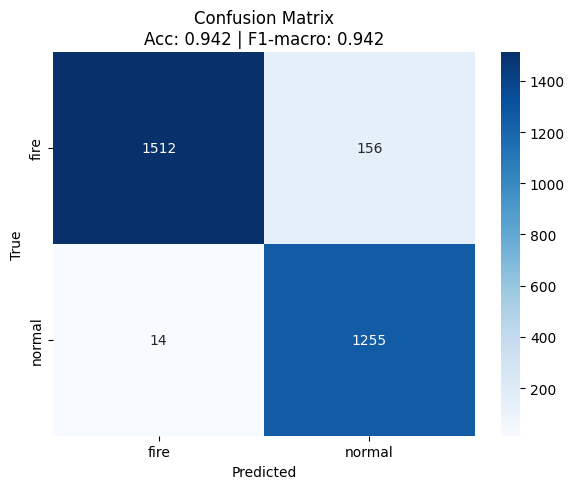


CLASS-WISE PERFORMANCE:
------------------------------
fire: 0.906 (1668 samples)
normal: 0.989 (1269 samples)

Results saved to 'model_predictions_full_dataset.csv'

CONFUSION MATRIX:
[[1512  156]
 [  14 1255]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        fire       0.99      0.91      0.95      1668
      normal       0.89      0.99      0.94      1269

    accuracy                           0.94      2937
   macro avg       0.94      0.95      0.94      2937
weighted avg       0.95      0.94      0.94      2937



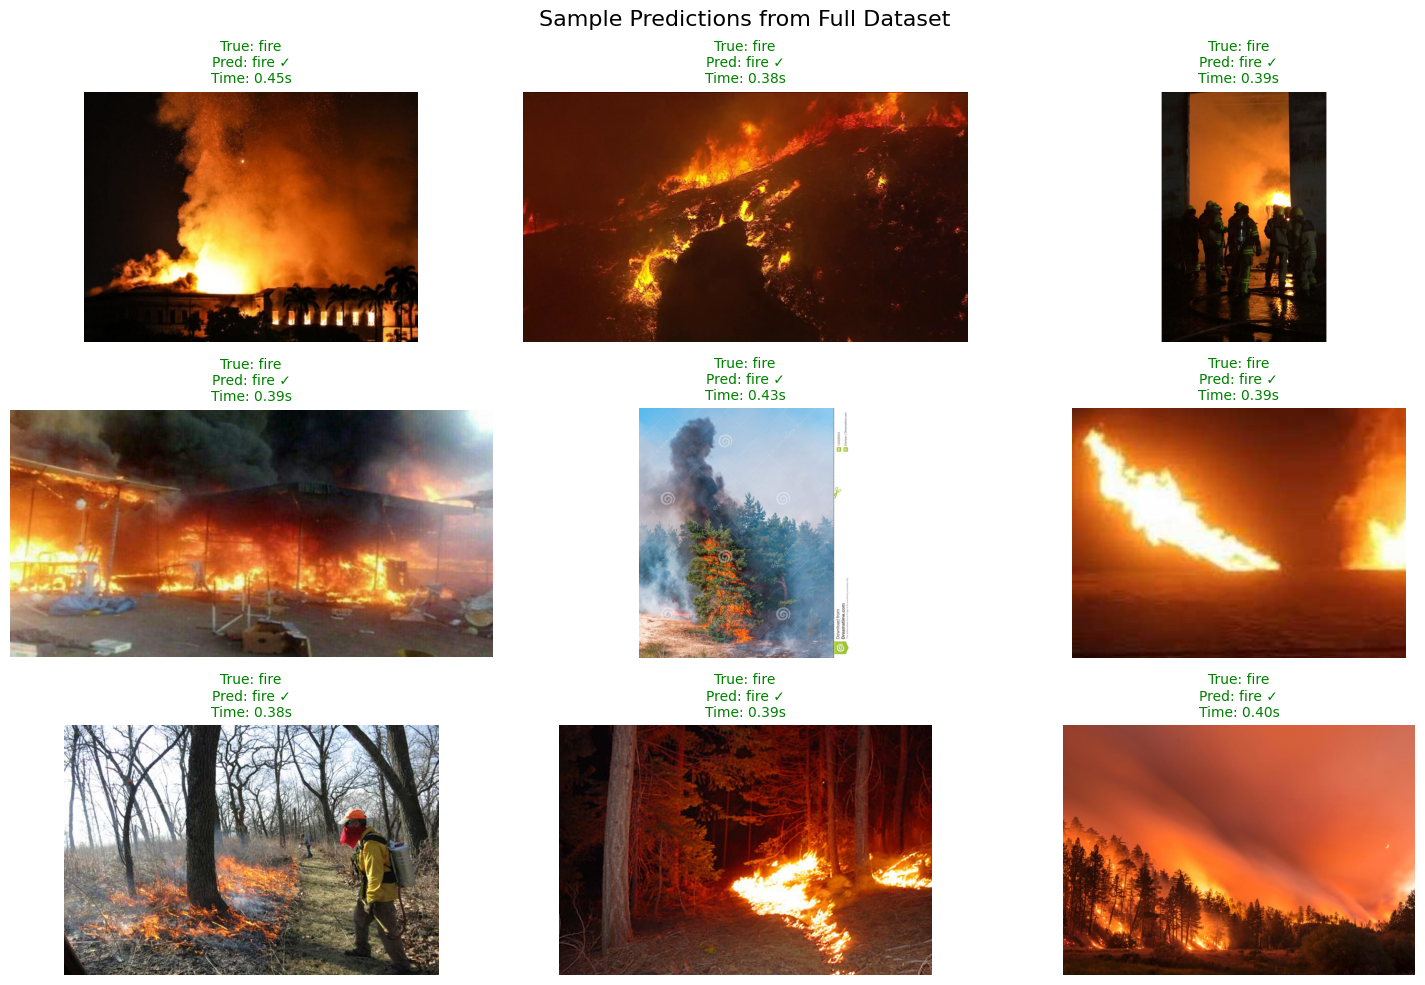


Found 170 incorrect predictions
Showing first few incorrect predictions:


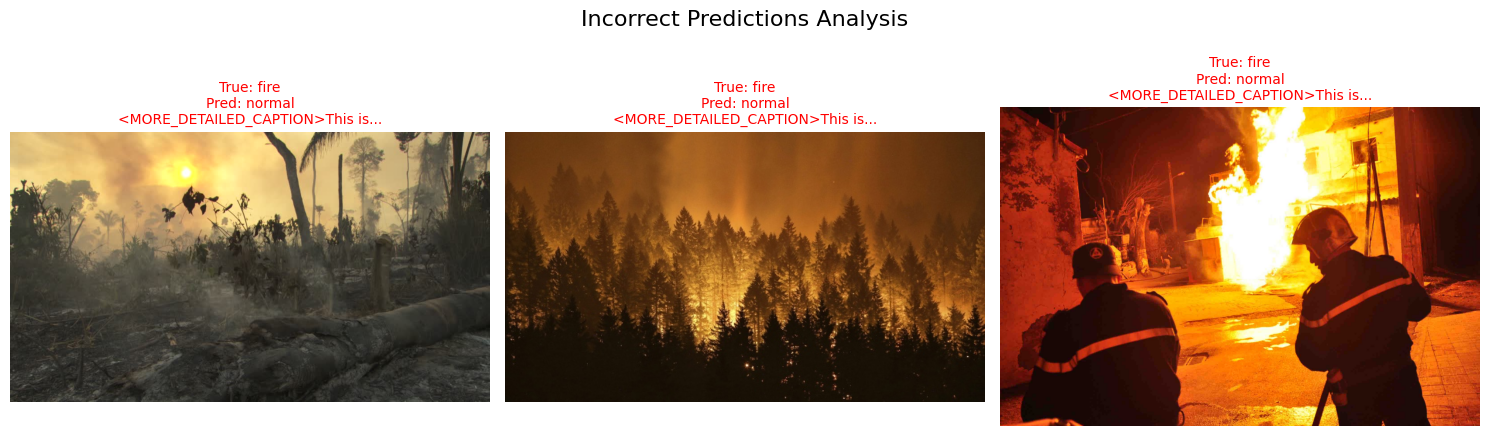

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns

if valid_predictions:
    valid_preds = [pred for pred, true in valid_predictions]
    valid_trues = [true for pred, true in valid_predictions]

    # 🔹 Compute confusion matrix
    cm = confusion_matrix(valid_trues, valid_preds)

    # 🔹 Compute metrics
    acc = accuracy_score(valid_trues, valid_preds)
    f1_macro = f1_score(valid_trues, valid_preds, average="macro")
    f1_micro = f1_score(valid_trues, valid_preds, average="micro")
    f1_weighted = f1_score(valid_trues, valid_preds, average="weighted")

    print("\nCONFUSION MATRIX (text):")
    print(cm)

    print("\nCLASSIFICATION REPORT:")
    print(classification_report(valid_trues, valid_preds, target_names=class_names))

    # 🔹 Plot confusion matrix with metrics
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix\nAcc: {acc:.3f} | F1-macro: {f1_macro:.3f}")
    plt.tight_layout()
    plt.show()


# Create detailed results DataFrame
results_df = pd.DataFrame({
    'image_path': all_image_paths,
    'true_label': [class_names[label] for label in all_true_labels],
    'predicted_label': [class_names[pred] if pred is not None else 'ERROR' for pred in all_predictions],
    'correct': [pred == true if pred is not None else False for pred, true in zip(all_predictions, all_true_labels)],
    'processing_time': all_processing_times,
    'generated_text': all_generated_texts
})

# Display class-wise accuracy
print("\nCLASS-WISE PERFORMANCE:")
print("-" * 30)
for class_idx, class_name in enumerate(class_names):
    class_mask = np.array(all_true_labels) == class_idx
    class_predictions = np.array(all_predictions)[class_mask]
    class_predictions = class_predictions[class_predictions != None]  # Remove failed predictions
    class_trues = np.array(all_true_labels)[class_mask][:len(class_predictions)]
    
    if len(class_predictions) > 0:
        class_accuracy = np.mean(class_predictions == class_trues)
        print(f"{class_name}: {class_accuracy:.3f} ({len(class_predictions)} samples)")

# Save results to CSV
results_df.to_csv('model_predictions_full_dataset.csv', index=False)
print(f"\nResults saved to 'model_predictions_full_dataset.csv'")

# Show confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
if valid_predictions:
    cm = confusion_matrix(valid_trues, valid_preds)
    print("\nCONFUSION MATRIX:")
    print(cm)
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(valid_trues, valid_preds, target_names=class_names))

# Visualize some sample results (first 9 images)
plt.figure(figsize=(15, 10))
for idx in range(min(9, len(all_image_paths))):
    if all_predictions[idx] is not None:
        image = Image.open(all_image_paths[idx])
        
        plt.subplot(3, 3, idx + 1)
        plt.imshow(image)
        plt.axis("off")
        
        true_label = class_names[all_true_labels[idx]]
        pred_label = class_names[all_predictions[idx]]
        is_correct = "✓" if all_predictions[idx] == all_true_labels[idx] else "✗"
        
        plt.title(f"True: {true_label}\nPred: {pred_label} {is_correct}\nTime: {all_processing_times[idx]:.2f}s", 
                 fontsize=10, color='green' if is_correct == "✓" else 'red')

plt.suptitle("Sample Predictions from Full Dataset", fontsize=16)
plt.tight_layout()
plt.show()

# Show some incorrect predictions for analysis
incorrect_indices = [i for i, (pred, true) in enumerate(zip(all_predictions, all_true_labels)) 
                    if pred is not None and pred != true]

if incorrect_indices:
    print(f"\nFound {len(incorrect_indices)} incorrect predictions")
    print("Showing first few incorrect predictions:")
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(incorrect_indices[:3]):  # Show first 3 incorrect
        image = Image.open(all_image_paths[idx])
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")
        
        true_label = class_names[all_true_labels[idx]]
        pred_label = class_names[all_predictions[idx]]
        
        plt.title(f"True: {true_label}\nPred: {pred_label}\n{all_generated_texts[idx][:30]}...", 
                 fontsize=10, color='red')
    
    plt.suptitle("Incorrect Predictions Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()

# Efficient_Net_V2_S

In [10]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s

class DisasterClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(DisasterClassifier, self).__init__()
        
        # Load pre-trained EfficientNetV2-S
        self.backbone = efficientnet_v2_s(weights='IMAGENET1K_V1')
        
        # Replace classifier
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [11]:
import torch
from huggingface_hub import hf_hub_download

# Specify repo + filename
REPO_ID = "Alasil/Florence_classification"
FILENAME = "best_model.pth"

# Download from HF Hub
MODEL_PATH = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load checkpoint
print(f"📥 Loading model from HF Hub: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# Extract info
class_names = checkpoint['class_names']
val_acc = checkpoint['val_acc']
epoch = checkpoint['epoch']

print(f"📊 Model Info:")
print(f"   Classes: {class_names}")
print(f"   Best validation accuracy: {val_acc:.2f}%")
print(f"   Trained for {epoch} epochs")

# Create model + load weights
model = DisasterClassifier(num_classes=len(class_names))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()

print("✅ Model loaded successfully from Hugging Face Hub!")


best_model.pth:   0%|          | 0.00/251M [00:00<?, ?B/s]

📥 Loading model from HF Hub: /root/.cache/huggingface/hub/models--Alasil--Florence_classification/snapshots/b78139b19350a7461bb870858cb4c70b9edd31af/best_model.pth
📊 Model Info:
   Classes: ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']
   Best validation accuracy: 98.67%
   Trained for 18 epochs


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 179MB/s]


✅ Model loaded successfully from Hugging Face Hub!


In [12]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

# 🔹 Define transforms (match your training preprocessing)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size based on your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 🔹 Create test dataset with transforms
test_dataset = datasets.ImageFolder(
    root="/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train",
    transform=test_transform
)

# 🔹 Create DataLoader
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2
)

print(f"Test dataset classes: {test_dataset.classes}")  # ['fire', 'nofire']
print(f"Number of test samples: {len(test_dataset)}")


Test dataset classes: ['fire', 'nofire']
Number of test samples: 2947


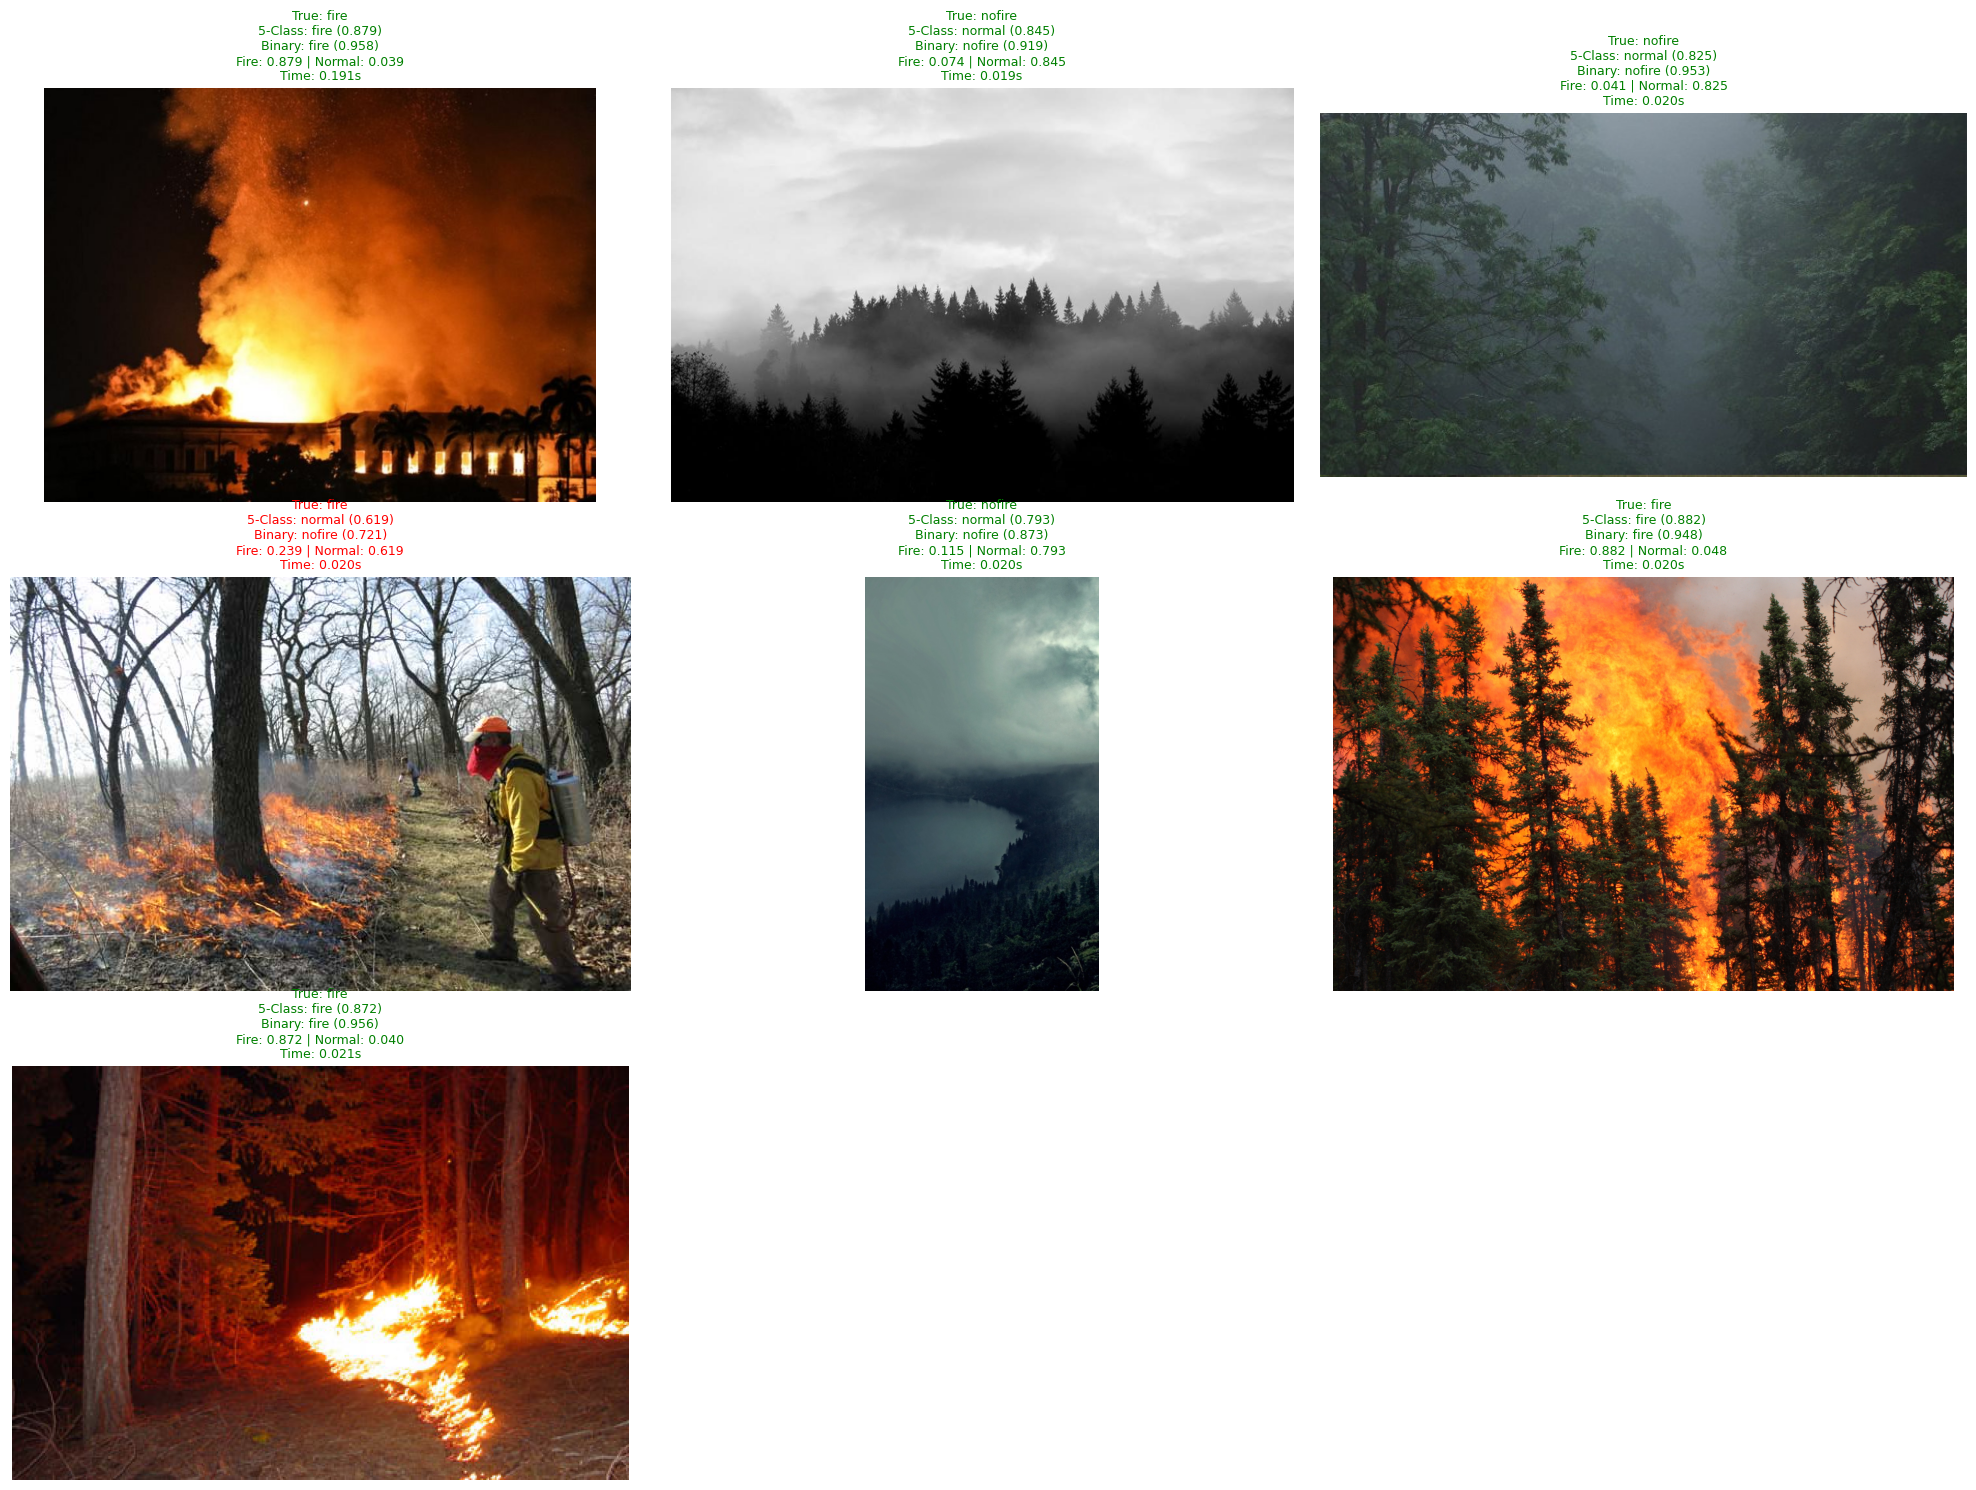

🔥 Individual Image Test Results

Image 1: 0001.png
   True: fire
   Binary Pred: fire (0.958) ✅
   5-Class Pred: fire (0.879) 🎯
   Fire Prob: 0.879 | Normal Prob: 0.039
   Inference Time: 0.191s

Image 2: 0001.png
   True: nofire
   Binary Pred: nofire (0.919) ✅
   5-Class Pred: normal (0.845) 🎯
   Fire Prob: 0.074 | Normal Prob: 0.845
   Inference Time: 0.019s

Image 3: 0005.png
   True: nofire
   Binary Pred: nofire (0.953) ✅
   5-Class Pred: normal (0.825) 🎯
   Fire Prob: 0.041 | Normal Prob: 0.825
   Inference Time: 0.020s

Image 4: 0007.png
   True: fire
   Binary Pred: nofire (0.721) ❌
   5-Class Pred: normal (0.619) 🎯
   Fire Prob: 0.239 | Normal Prob: 0.619
   Inference Time: 0.020s

Image 5: 0011.png
   True: nofire
   Binary Pred: nofire (0.873) ✅
   5-Class Pred: normal (0.793) 🎯
   Fire Prob: 0.115 | Normal Prob: 0.793
   Inference Time: 0.020s

Image 6: 0010.png
   True: fire
   Binary Pred: fire (0.948) ✅
   5-Class Pred: fire (0.882) 🎯
   Fire Prob: 0.882 | Normal Prob: 

In [13]:
import time
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the same transforms used in training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Your model's class names
original_class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]
binary_class_names = ["fire", "nofire"]

# Test image paths
image_paths = [
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0001.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0001.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0005.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0007.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/nofire/0011.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0010.png",
    "/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train/fire/0008.png"
]

def predict_single_image(model, image_path, transform, device):
    """
    Predict single image using your disaster classification model
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get model prediction
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Get 5-class prediction
    confidence_5class, predicted_5class = torch.max(probabilities, 1)
    
    # Binary classification (fire vs normal)
    fire_prob = probabilities[0, 1].item()    # Fire class probability
    normal_prob = probabilities[0, 3].item()  # Normal class probability
    
    # Binary decision
    if fire_prob > normal_prob:
        binary_pred = 0  # Fire
        binary_confidence = fire_prob
    else:
        binary_pred = 1  # No fire
        binary_confidence = normal_prob
    
    # Normalize binary confidence
    total_relevant_prob = fire_prob + normal_prob
    normalized_confidence = (fire_prob if binary_pred == 0 else normal_prob) / (total_relevant_prob + 1e-8)
    
    return {
        'image': image,
        '5class_pred': predicted_5class.item(),
        '5class_confidence': confidence_5class.item(),
        '5class_name': original_class_names[predicted_5class.item()],
        'binary_pred': binary_pred,
        'binary_confidence': normalized_confidence,
        'binary_name': binary_class_names[binary_pred],
        'fire_prob': fire_prob,
        'normal_prob': normal_prob,
        'inference_time': inference_time,
        'all_probs': probabilities[0].cpu().numpy()
    }

# Test all images
plt.figure(figsize=(20, 15))

results = []
for idx, img_path in enumerate(image_paths):
    # Get true label from path
    true_label = "fire" if "/fire/" in img_path else "nofire"
    
    # Predict
    result = predict_single_image(model, img_path, test_transform, DEVICE)
    result['true_label'] = true_label
    result['path'] = img_path
    results.append(result)
    
    # Plot
    plt.subplot(3, 3, idx + 1)
    plt.imshow(result['image'])
    plt.axis("off")
    
    # Create title with predictions
    title = f"True: {true_label}\n"
    title += f"5-Class: {result['5class_name']} ({result['5class_confidence']:.3f})\n"
    title += f"Binary: {result['binary_name']} ({result['binary_confidence']:.3f})\n"
    title += f"Fire: {result['fire_prob']:.3f} | Normal: {result['normal_prob']:.3f}\n"
    title += f"Time: {result['inference_time']:.3f}s"
    
    # Color code the title based on correctness
    color = 'green' if result['binary_name'] == true_label else 'red'
    plt.title(title, fontsize=9, color=color)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("🔥 Individual Image Test Results")
print("="*80)

correct_binary = 0
correct_5class = 0

for i, result in enumerate(results):
    true_binary = result['true_label']
    pred_binary = result['binary_name']
    pred_5class = result['5class_name']
    
    binary_correct = "✅" if pred_binary == true_binary else "❌"
    class_relevant = "🎯" if pred_5class in ['fire', 'normal'] else "🔀"
    
    print(f"\nImage {i+1}: {result['path'].split('/')[-1]}")
    print(f"   True: {true_binary}")
    print(f"   Binary Pred: {pred_binary} ({result['binary_confidence']:.3f}) {binary_correct}")
    print(f"   5-Class Pred: {pred_5class} ({result['5class_confidence']:.3f}) {class_relevant}")
    print(f"   Fire Prob: {result['fire_prob']:.3f} | Normal Prob: {result['normal_prob']:.3f}")
    print(f"   Inference Time: {result['inference_time']:.3f}s")
    
    if pred_binary == true_binary:
        correct_binary += 1
    if (true_binary == "fire" and pred_5class == "fire") or (true_binary == "nofire" and pred_5class == "normal"):
        correct_5class += 1

# Summary statistics
total_images = len(results)
binary_accuracy = correct_binary / total_images * 100
class5_accuracy = correct_5class / total_images * 100
avg_time = sum(r['inference_time'] for r in results) / total_images

print(f"\n📊 Summary Statistics:")
print(f"   Binary Accuracy: {correct_binary}/{total_images} ({binary_accuracy:.1f}%)")
print(f"   5-Class Relevant Accuracy: {correct_5class}/{total_images} ({class5_accuracy:.1f}%)")
print(f"   Average Inference Time: {avg_time:.3f}s")
print(f"   Total Images Tested: {total_images}")

# Show probability distributions
print(f"\n📈 Probability Analysis:")
fire_images = [r for r in results if r['true_label'] == 'fire']
nofire_images = [r for r in results if r['true_label'] == 'nofire']

if fire_images:
    avg_fire_prob_for_fire = sum(r['fire_prob'] for r in fire_images) / len(fire_images)
    print(f"   Average fire probability for fire images: {avg_fire_prob_for_fire:.3f}")

if nofire_images:
    avg_fire_prob_for_nofire = sum(r['fire_prob'] for r in nofire_images) / len(nofire_images)
    print(f"   Average fire probability for no-fire images: {avg_fire_prob_for_nofire:.3f}")


In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Dataset setup
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (match your training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load complete dataset
print("🔄 Loading complete binary fire dataset...")
full_dataset = datasets.ImageFolder(
    root="/kaggle/input/fire-non/Forest Fire Dataset/ForestFireDataset(Classifications)/ForestFireDataset/train",
    transform=test_transform
)

full_loader = DataLoader(
    full_dataset, 
    batch_size=64,  # Larger batch size for faster processing
    shuffle=False, 
    num_workers=4
)

print(f"📊 Dataset Info:")
print(f"   Classes: {full_dataset.classes}")  # ['fire', 'nofire']
print(f"   Total samples: {len(full_dataset)}")
print(f"   Fire samples: {len([x for x in full_dataset.targets if x == 0])}")
print(f"   No-fire samples: {len([x for x in full_dataset.targets if x == 1])}")

# Model class names
original_class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]
binary_class_names = ["fire", "nofire"]


🔄 Loading complete binary fire dataset...
📊 Dataset Info:
   Classes: ['fire', 'nofire']
   Total samples: 2947
   Fire samples: 1672
   No-fire samples: 1275


In [15]:
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, f1_score
)
from tqdm import tqdm
import numpy as np
import torch
from PIL import Image

def evaluate_full_dataset_FIXED(model, dataloader, device):
    """
    FIXED evaluation with correct label mapping + report + timing + visuals
    """
    print("🔥 Evaluating with FIXED label mapping...")
    
    model.eval()
    all_binary_preds = []
    all_binary_labels = []
    all_fire_probs = []
    all_normal_probs = []
    
    fire_idx = 1    # 'fire' in your 5-class model
    normal_idx = 3  # 'normal' in your 5-class model

    total_time = 0
    total_samples = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Processing (FIXED)')
        
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            elapsed = time.time() - start_time
            
            probabilities = torch.softmax(outputs, dim=1)
            fire_probs = probabilities[:, fire_idx].cpu().numpy()
            normal_probs = probabilities[:, normal_idx].cpu().numpy()
            
            binary_preds = (normal_probs > fire_probs).astype(int)  # 1 = nofire, 0 = fire
            
            all_binary_preds.extend(binary_preds)
            all_binary_labels.extend(labels.cpu().numpy())
            all_fire_probs.extend(fire_probs)
            all_normal_probs.extend(normal_probs)
            
            total_time += elapsed
            total_samples += len(images)
            
            if len(all_binary_labels) > 0:
                current_acc = accuracy_score(all_binary_labels, all_binary_preds) * 100
                pbar.set_postfix({'Acc': f'{current_acc:.2f}%'})
    
    preds = np.array(all_binary_preds)
    labels = np.array(all_binary_labels)
    fire_probs = np.array(all_fire_probs)
    normal_probs = np.array(all_normal_probs)
    
    # ✅ Metrics
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    f1_micro = f1_score(labels, preds, average="micro")
    f1_weighted = f1_score(labels, preds, average="weighted")

    print("\n📊 Classification Report:")
    print(classification_report(labels, preds, target_names=["fire", "nofire"]))
    print(f"🎯 Accuracy: {acc:.4f}")
    print(f"📈 F1 Macro: {f1_macro:.4f}")
    print(f"📈 F1 Micro: {f1_micro:.4f}")
    print(f"📈 F1 Weighted: {f1_weighted:.4f}")
    
    # ✅ Average processing time
    avg_time_per_batch = total_time / len(dataloader)
    avg_time_per_sample = total_time / total_samples
    print(f"\n⏱️ Avg Time per Batch: {avg_time_per_batch:.4f} sec")
    print(f"⏱️ Avg Time per Sample: {avg_time_per_sample*1000:.4f} ms")
    
    # ✅ Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["fire","nofire"], yticklabels=["fire","nofire"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # ✅ ROC Curve (binary)
    fpr, tpr, _ = roc_curve(labels, normal_probs)  # use nofire probs since label=1 = "nofire"
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Fire vs NoFire)")
    plt.legend()
    plt.show()

    # ✅ Correct & Wrong Examples
    image_paths = [s[0] for s in dataloader.dataset.samples]  # works for ImageFolder
    class_names = ["fire", "nofire"]

    correct_indices = [i for i in range(len(preds)) if preds[i] == labels[i]]
    wrong_indices   = [i for i in range(len(preds)) if preds[i] != labels[i]]

    def plot_examples(indices, title, color):
        if not indices:
            print(f"No {title.lower()} to display.")
            return
        chosen = random.sample(indices, min(4, len(indices)))
        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(chosen):
            img = Image.open(image_paths[idx])
            plt.subplot(1, len(chosen), i + 1)
            plt.imshow(img)
            plt.axis("off")
            true_label = class_names[labels[idx]]
            pred_label = class_names[preds[idx]]
            plt.title(
                f"T: {true_label}\nP: {pred_label}",
                fontsize=10, color=color
            )
        plt.suptitle(title, fontsize=14)
        plt.show()

    plot_examples(correct_indices, "✅ Correct Predictions", "green")
    plot_examples(wrong_indices, "❌ Wrong Predictions", "red")

    return preds, labels, fire_probs, normal_probs


🔥 Evaluating with FIXED label mapping...


Processing (FIXED): 100%|██████████| 93/93 [01:11<00:00,  1.30it/s, Acc=92.16%]



📊 Classification Report:
              precision    recall  f1-score   support

        fire       0.99      0.87      0.93      1672
      nofire       0.85      0.99      0.92      1275

    accuracy                           0.92      2947
   macro avg       0.92      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947

🎯 Accuracy: 0.9216
📈 F1 Macro: 0.9213
📈 F1 Micro: 0.9216
📈 F1 Weighted: 0.9220

⏱️ Avg Time per Batch: 0.0210 sec
⏱️ Avg Time per Sample: 0.6642 ms


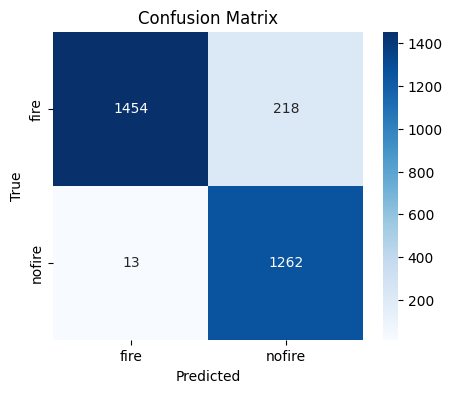

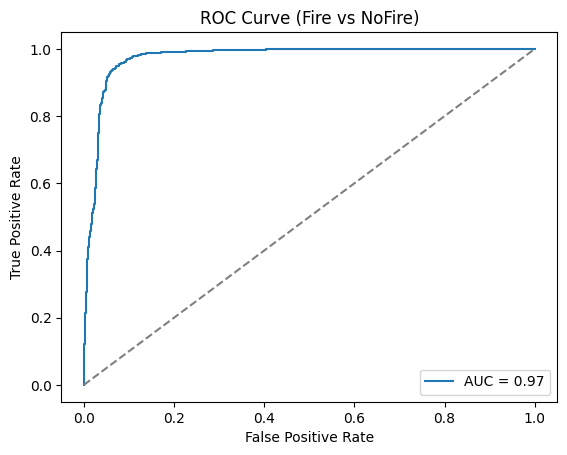

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


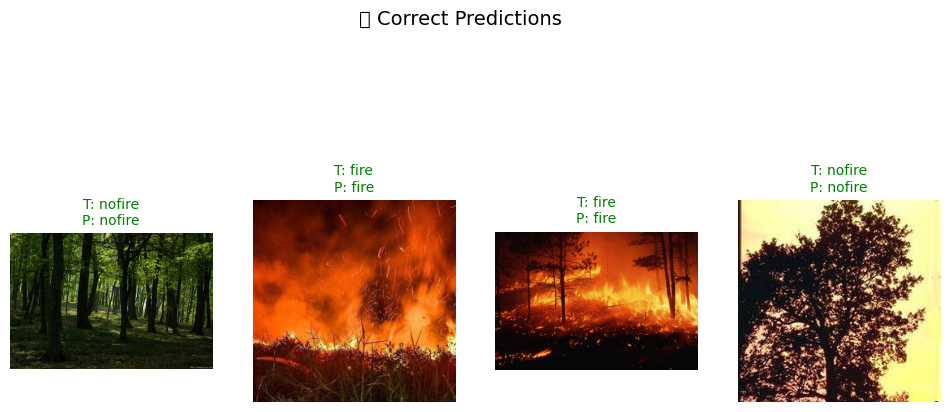

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


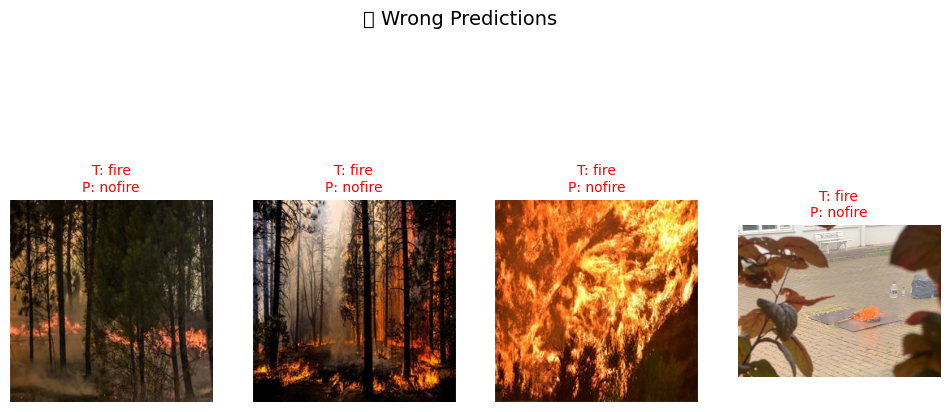

In [16]:
test_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)
preds, labels, fire_probs, normal_probs = evaluate_full_dataset_FIXED(model, test_loader, DEVICE)
